# Trajectory Optimization of Pendulum
### Training data for a NN based controller

Perform the trajectory optimization of a single link pendulum using 3-point Radau. The pendulum is actuated at the base.

<img src="Images/pendulum.png" width="200">

In [75]:
import pendulum, utils, numpy as np
from importlib import reload
import time
reload(pendulum)

angles = 'abs'  # 'abs' or 'rel'
num_links = 1   # for these tests, from 2 to 8
nfe = 150
collocation = 'euler'  # either 'euler' or 'radau'
total_time = 3.0
iterations = 1000

EOM = pendulum.get_N_link_EOM(num_links=num_links, angles=angles, lambdify=True)


In [79]:
# m.q.pprint()

In [86]:
# Iterate and solve
from datetime import datetime

# datetime object containing current date and time 
now = datetime.now() # dd/mm/YY H:M:S
dt_string = now.strftime("%d_%m_%Y_%H_%M")

success_solves = 0
failed_solves = 0

print('{0:<15s}{1:<15s}{2:<15s}'.format("Iteration","Solved","Time(s)"))

for i in range(iterations):
    
    
    m = pendulum.make_pyomo_model([EOM], nfe=nfe, angles=angles, collocation=collocation, total_time=total_time)
    
    try:
        start = time.time()
        # solving
        results = pendulum.default_solver(output_file = '##', max_mins=5).solve(m, tee=False)
        end = time.time()

    except:
        print("Something went wrong with solve...")
        failed_solves += 1
        continue
    
    print('{0:<15s}{1:<15s}{2:<15f}'.format(str(i+1)+"/"+str(iterations), str(results.solver.termination_condition),end-start))
    
    if str(results.solver.termination_condition) == "optimal":
        
        if (collocation == 'euler'):
            th_ar = np.zeros(nfe)
            dth_ar = np.zeros(nfe)
            ddth_ar = np.zeros(nfe)
            Tc_ar = np.zeros(nfe)
            
            for j in range(1,nfe+1):
                th_ar[j-1] = m.q[j,1,1].value
                dth_ar[j-1] = m.dq[j,1,1].value
                ddth_ar[j-1] = m.ddq[j,1,1].value
                Tc_ar[j-1] = m.Tc[j,1].value
        else:
            th_ar = np.zeros(3*nfe)
            dth_ar = np.zeros(3*nfe)
            ddth_arr = np.zeros(3*nfe)
            Tc_ar = np.zeros(nfe)
            
            for j in range(1,nfe+1):
                for k in range(1,4):
                    th_ar[3*(j-1)+k-1] = m.q[j,k,1].value
                    dth_ar[3*(j-1)+k-1] = m.dq[j,k,1].value
                    ddth_ar[3*(j-1)+k-1] = m.ddq[j,k,1].value
                Tc_ar[j-1] = m.Tc[j,1].value
    
        filename = "iter_" + str(i+1) + '_' + dt_string+ ".npy"
        filepath = "./Datasets/pendulum_no_disturbance_euler/"
        file = filepath + filename
        np.save(file, [th_ar, dth_ar, ddth_ar, Tc_ar])
        
        success_solves += 1    
    
    else: 
        print("Failed")
        failed_solves += 1
        
print("---------------------------------------------------------------------")
print("Batch finished.")
print("Percetage sucessful solves:", round(success_solves/iterations*100), "%")

Iteration      Solved         Time(s)        
1/1000         optimal        0.128173       
2/1000         optimal        0.143283       
3/1000         optimal        0.132977       
4/1000         optimal        0.140457       
5/1000         optimal        0.153369       
6/1000         optimal        0.119925       
7/1000         optimal        0.153632       
8/1000         optimal        0.208896       
9/1000         optimal        0.131721       
10/1000        optimal        0.125023       
11/1000        optimal        0.150255       
12/1000        optimal        0.257418       
13/1000        optimal        0.147570       
14/1000        optimal        0.139282       
15/1000        optimal        0.125233       
16/1000        optimal        0.122827       
17/1000        optimal        0.169376       
18/1000        optimal        0.130256       
19/1000        optimal        0.121298       
20/1000        optimal        0.132054       
21/1000        optimal        0.13

In [87]:
th = utils.get_vals2(m, m.q, (m.links,))[:,0,:]
Tc = utils.get_vals2(m, m.Tc, (m.links,))
ONES = np.array([1]*num_links)

if angles == 'rel':
    for link in range(1, num_links):
        th[:, link] += th[:, link-1]

pendulum.make_animation(th, ONES, ONES, Tc, num_links, th.shape[0], total_time/nfe)

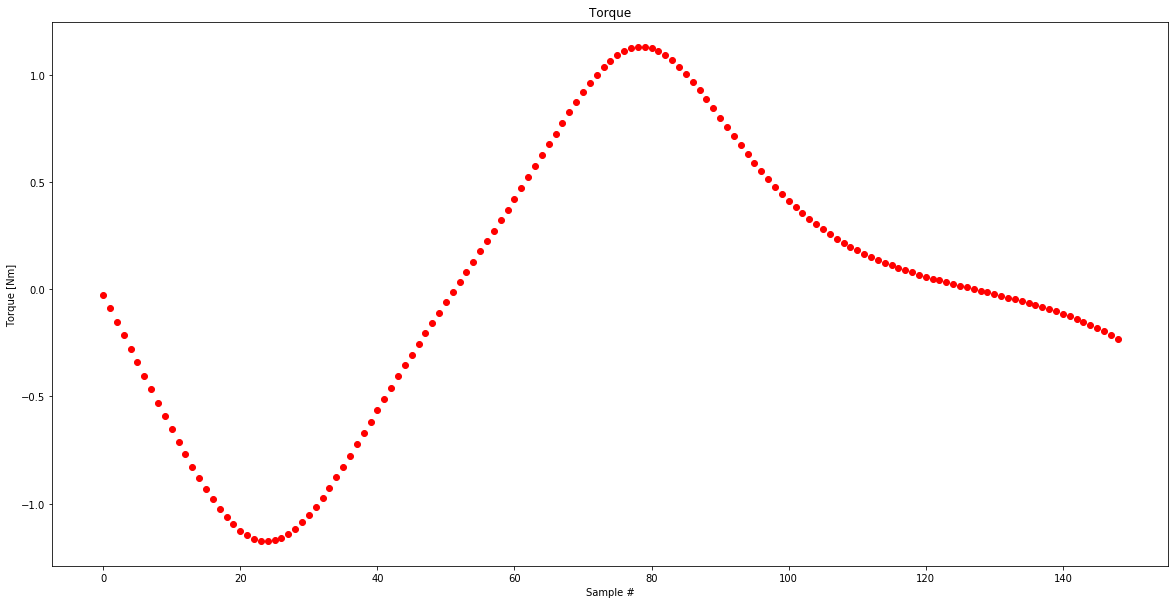

In [89]:
import matplotlib
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(Tc_ar[1:], 'ro')

ax.set(xlabel='Sample #', ylabel='Torque [Nm]',
       title='Torque');

In [97]:
# m.Tc.pprint()
# m.hm.pprint()